In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import metrics

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thuch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data = pd.read_csv('uci-news-aggregator.csv')

In [5]:
data = data[['TITLE','CATEGORY']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   TITLE     422419 non-null  object
 1   CATEGORY  422419 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [7]:
data.describe()

,TITLE,CATEGORY
count,422419,422419
unique,406455,4
top,The article requested cannot be found! Please ...,e
freq,145,152469


Exploratory Data Analysis

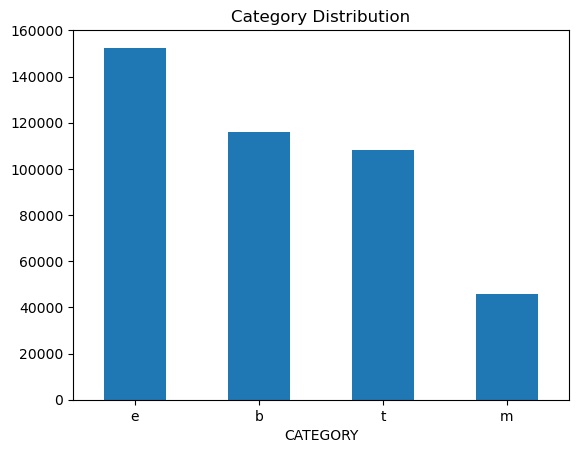

In [8]:
data['CATEGORY'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.title('Category Distribution')
plt.show()

Preprocessing

In [10]:
#lowercasing
data['TITLE'] = data['TITLE'].str.lower()

In [12]:
#removing punctuation
data['TITLE'] = data['TITLE'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))

In [14]:
#remove stop words
data['TITLE'] = data['TITLE'].apply(lambda x: ' '.join(i for i in x.split() if i not in set(stopwords.words('english'))))

In [40]:
#lemmatizer
data['TITLE'] = data['TITLE'].apply(lambda x: ' '.join(WordNetLemmatizer().lemmatize(w) for w in x.split()) )

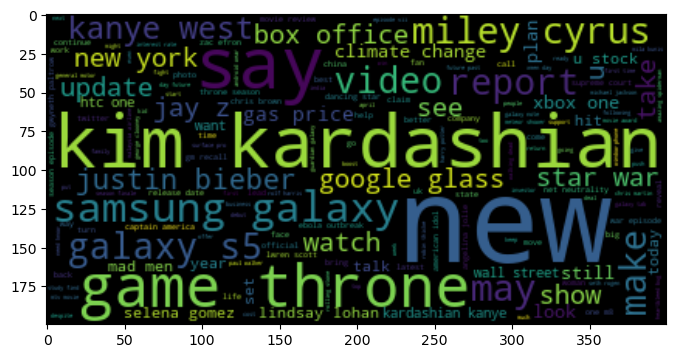

In [118]:
#visualization - word cloud
wordcloud = WordCloud().generate(' '.join(data['TITLE']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')

In [49]:
from collections import Counter
cnt = Counter()
for text in data["TITLE"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(15)

[('new', 24213),
 ('u', 18920),
 ('google', 12436),
 ('say', 10914),
 ('apple', 10114),
 ('video', 9912),
 ('2014', 9322),
 ('report', 8274),
 ('star', 8072),
 ('get', 8037),
 ('show', 8007),
 ('first', 7951),
 ('may', 7765),
 ('samsung', 7575),
 ('stock', 7516)]

In [53]:
len(cnt)

69293

In [82]:
#preparing train-test set
#label encoding target values
target_labels = pd.get_dummies(data['CATEGORY'])
data = pd.concat([data, target_labels], axis=1)

In [75]:
#tokenizer
tokenizer = Tokenizer(num_words=30000) #half number of words
tokenizer.fit_on_texts(data['TITLE'])
sequences = tokenizer.texts_to_sequences(data['TITLE'])
title_padded = pad_sequences(sequences, maxlen=5)

In [86]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(title_padded,
                                                  data[['b','e','m','t']].values,
                                                  stratify=data['CATEGORY'],
                                                  test_size=0.2, random_state=42)

In [112]:
# Create the model
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim= 30000, output_dim=50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(120),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 50)          1500000   
                                                                 
 dropout_18 (Dropout)        (None, None, 50)          0         
                                                                 
 lstm_9 (LSTM)               (None, 120)               82080     
                                                                 
 dense_30 (Dense)            (None, 120)               14520     
                                                                 
 dropout_19 (Dropout)        (None, 120)               0         
                                                                 
 dense_31 (Dense)            (None, 50)                6050      
                                                                 
 dropout_20 (Dropout)        (None, 50)              

In [114]:
history = lstm.fit(X_train, y_train, epochs=10,
                   validation_data=(X_val, y_val),  batch_size=120)

Epoch 1/10
2817/2817 [==============================] - 137s 49ms/step - loss: 0.3404 - accuracy: 0.8829 - val_loss: 0.2877 - val_accuracy: 0.8985
Epoch 2/10
2817/2817 [==============================] - 133s 47ms/step - loss: 0.2630 - accuracy: 0.9082 - val_loss: 0.2767 - val_accuracy: 0.9025
Epoch 3/10
2817/2817 [==============================] - 130s 46ms/step - loss: 0.2321 - accuracy: 0.9179 - val_loss: 0.2718 - val_accuracy: 0.9031
Epoch 4/10
2817/2817 [==============================] - 128s 45ms/step - loss: 0.2071 - accuracy: 0.9260 - val_loss: 0.2829 - val_accuracy: 0.9046
Epoch 5/10
2817/2817 [==============================] - 125s 44ms/step - loss: 0.1882 - accuracy: 0.9317 - val_loss: 0.2841 - val_accuracy: 0.9061
Epoch 6/10
2817/2817 [==============================] - 133s 47ms/step - loss: 0.1727 - accuracy: 0.9370 - val_loss: 0.2967 - val_accuracy: 0.9062
Epoch 7/10
2817/2817 [==============================] - 141s 50ms/step - loss: 0.1596 - accuracy: 0.9411 - val_loss: 0

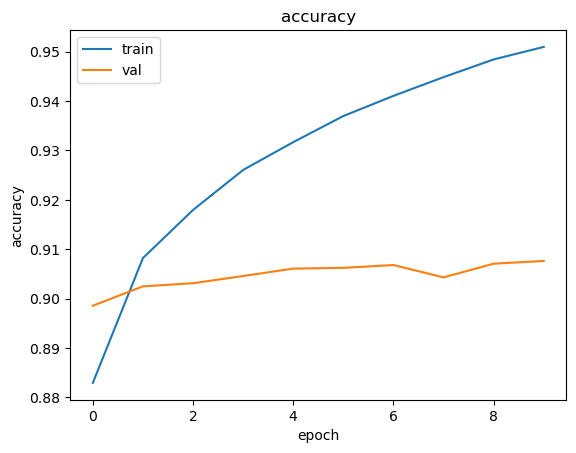

In [115]:
# Visualize LSTM history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()